In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from pathlib import Path
import warnings
from tqdm.auto import tqdm
import ast
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

In [12]:
# Create directories for NHANES data
Path('NHANES/raw').mkdir(parents=True, exist_ok=True)
Path('NHANES/processed').mkdir(parents=True, exist_ok=True)
Path('Analysis').mkdir(exist_ok=True)

### Download NHANES Data (2017-2020 Pre-Pandemic)

- **P_DR1TOT**: Day 1 Total Nutrient Intakes (18.4 MB)
- **P_DR2TOT**: Day 2 Total Nutrient Intakes (9.3 MB)
- **P_DEMO**: Demographics (3.4 MB)

In [19]:
def download_nhanes_file(url, filename, description):
    """
    Download a single NHANES XPT file with progress bar.
    """
    output_path = Path(f"NHANES/raw/{filename}")
    
    print(f"\nDownloading {description}...")
    
    try:
        response = requests.get(url, stream=True, timeout=120)
        response.raise_for_status()
        
        total_size = int(response.headers.get('content-length', 0))
        
        with open(output_path, 'wb') as f:
            with tqdm(total=total_size, unit='iB', unit_scale=True, desc=filename) as pbar:
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
                        pbar.update(len(chunk))
        
        print(f"  Downloaded successfully: {output_path}")
        return str(output_path)
        
    except Exception as e:
        print(f"  Error downloading {description}: {str(e)}")
        return None

In [ ]:
def download_nhanes_2017_2020():
    """
    Download NHANES 2017-2020 Pre-Pandemic dietary and demographic data.
    """
    base_url = "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles"
    
    files = {
        'dietary_day1': {
            'url': f"{base_url}/P_DR1TOT.XPT",
            'filename': 'P_DR1TOT.XPT',
            'description': 'Day 1 Total Nutrient Intakes (2017-2020)'
        },
        'dietary_day2': {
            'url': f"{base_url}/P_DR2TOT.XPT",
            'filename': 'P_DR2TOT.XPT',
            'description': 'Day 2 Total Nutrient Intakes (2017-2020)'
        },
        'demographics': {
            'url': f"{base_url}/P_DEMO.XPT",
            'filename': 'P_DEMO.XPT',
            'description': 'Demographics (2017-2020)'
        }
    }

    
    downloaded_files = {}
    
    for key, file_info in files.items():
        result = download_nhanes_file(
            file_info['url'],
            file_info['filename'],
            file_info['description']
        )
        if result:
            downloaded_files[key] = result
    
    return downloaded_files

nhanes_files = download_nhanes_2017_2020()

P_DR1TOT.XPT: 19.2MiB [00:01, 12.8MiB/s]


  Downloaded successfully: NHANES/raw/P_DR1TOT.XPT



P_DR2TOT.XPT: 9.74MiB [00:01, 8.56MiB/s]


  Downloaded successfully: NHANES/raw/P_DR2TOT.XPT



P_DEMO.XPT: 3.61MiB [00:00, 14.7MiB/s]

  Downloaded successfully: NHANES/raw/P_DEMO.XPT


In [ ]:
def load_nhanes_xpt_files(file_paths):
    """
    Load NHANES XPT (SAS Transport) files into pandas DataFrames.
    """
    datasets = {}
    
    for key, filepath in file_paths.items():
        if filepath and Path(filepath).exists():
            print(f"\nLoading {key}...")
            try:
                df = pd.read_sas(filepath, format='xport', encoding='utf-8')
                datasets[key] = df
                print(f"  Loaded {len(df):,} records with {len(df.columns)} columns")
            except Exception as e:
                print(f"  Error loading {key}: {str(e)}")
        else:
            print(f"  File not found: {filepath}")
    
    return datasets

nhanes_data = load_nhanes_xpt_files(nhanes_files)


Loading dietary_day1...
  Loaded 14,300 records with 168 columns

Loading dietary_day2...
  Loaded 14,300 records with 85 columns

Loading demographics...
  Loaded 15,560 records with 29 columns


## 5. Process NHANES Dietary Data

In [ ]:
def process_nhanes_dietary_data(dietary_day1, dietary_day2, demographics):
    """
    Process and combine NHANES dietary data.
    
    Key nutrients (NHANES variable names):
    - DR1TKCAL / DR2TKCAL: Energy (kcal)
    - DR1TPROT / DR2TPROT: Protein (g)
    - DR1TCARB / DR2TCARB: Carbohydrates (g)
    - DR1TTFAT / DR2TTFAT: Total Fat (g)
    - DR1TFIBE / DR2TFIBE: Fiber (g)
    - DR1TSUGR / DR2TSUGR: Sugar (g)
    - DR1TSODI / DR2TSODI: Sodium (mg)
    """
        
    nutrient_cols_day1 = {
        'SEQN': 'respondent_id',
        'DR1TKCAL': 'energy_kcal',
        'DR1TPROT': 'protein_g',
        'DR1TCARB': 'carbs_g',
        'DR1TTFAT': 'fat_g',
        'DR1TFIBE': 'fiber_g',
        'DR1TSUGR': 'sugar_g',
        'DR1TSODI': 'sodium_mg'
    }
    
    available_cols = [col for col in nutrient_cols_day1.keys() if col in dietary_day1.columns]
    df_day1 = dietary_day1[available_cols].copy()
    df_day1.columns = [nutrient_cols_day1[col] for col in available_cols]
    df_day1['day'] = 1
    
    nutrient_cols_day2 = {k.replace('DR1', 'DR2'): v for k, v in nutrient_cols_day1.items()}
    available_cols_day2 = [col for col in nutrient_cols_day2.keys() if col in dietary_day2.columns]
    df_day2 = dietary_day2[available_cols_day2].copy()
    df_day2.columns = [nutrient_cols_day2[col] for col in available_cols_day2]
    df_day2['day'] = 2
    
    df_combined = pd.concat([df_day1, df_day2], ignore_index=True)
    
    demo_cols = {
        'SEQN': 'respondent_id',
        'RIAGENDR': 'gender', 
        'RIDAGEYR': 'age',
        'RIDRETH3': 'race_ethnicity'
    }
    
    available_demo = [col for col in demo_cols.keys() if col in demographics.columns]
    df_demo = demographics[available_demo].copy()
    df_demo.columns = [demo_cols[col] for col in available_demo]
    
    df_final = df_combined.merge(df_demo, on='respondent_id', how='left')
    
    df_final = df_final.dropna(subset=['energy_kcal', 'protein_g', 'carbs_g', 'fat_g'])
    
    print(f"  Processed {len(df_final):,} dietary records")
    print(f"  Unique respondents: {df_final['respondent_id'].nunique():,}")
    
    return df_final

df_nhanes = process_nhanes_dietary_data(
    nhanes_data['dietary_day1'],
    nhanes_data['dietary_day2'],
    nhanes_data['demographics']
)

df_nhanes.to_csv('NHANES/processed/nhanes_dietary_processed.csv', index=False)
print("\n Saved to: NHANES/processed/nhanes_dietary_processed.csv")

  Processed 23,019 dietary records
  Unique respondents: 12,409

 Saved to: NHANES/processed/nhanes_dietary_processed.csv


In [ ]:
df_recipes = pd.read_csv('Allrecipes.csv')
print(f"  Loaded {len(df_recipes):,} recipes")

chunk_files = sorted(Path('OpenFoodFacts/processed').glob('chunk_*.csv'))
df_off = pd.concat([pd.read_csv(f) for f in chunk_files[:5]], ignore_index=True)
print(f"  Loaded {len(df_off):,} food products (sample)")

df_nhanes = pd.read_csv('NHANES/processed/nhanes_dietary_processed.csv')
print(f"  Loaded {len(df_nhanes):,} dietary records")

  Loaded 38,237 recipes
  Loaded 250,001 food products (sample)
  Loaded 23,019 dietary records


In [24]:
print(f"\nDataset Shape: {df_nhanes.shape}")
print(f"Unique Respondents: {df_nhanes['respondent_id'].nunique():,}")

print("\nData Info:")
print(df_nhanes.info())


Dataset Shape: (23019, 12)
Unique Respondents: 12,409

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23019 entries, 0 to 23018
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   respondent_id   23019 non-null  float64
 1   energy_kcal     23019 non-null  float64
 2   protein_g       23019 non-null  float64
 3   carbs_g         23019 non-null  float64
 4   fat_g           23019 non-null  float64
 5   fiber_g         23019 non-null  float64
 6   sugar_g         23019 non-null  float64
 7   sodium_mg       23019 non-null  float64
 8   day             23019 non-null  int64  
 9   gender          23019 non-null  float64
 10  age             23019 non-null  float64
 11  race_ethnicity  23019 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 2.1 MB
None


In [25]:
print("\nNutritional Statistics (per day):")
nutrient_cols = ['energy_kcal', 'protein_g', 'carbs_g', 'fat_g', 'fiber_g', 'sugar_g', 'sodium_mg']
available_nutrients = [col for col in nutrient_cols if col in df_nhanes.columns]
print(df_nhanes[available_nutrients].describe())


Nutritional Statistics (per day):
        energy_kcal     protein_g       carbs_g         fat_g       fiber_g  \
count  2.301900e+04  2.301900e+04  2.301900e+04  2.301900e+04  2.301900e+04   
mean   1.913869e+03  7.103695e+01  2.289031e+02  7.757951e+01  1.475593e+01   
std    9.487916e+02  3.988359e+01  1.191844e+02  4.591921e+01  9.838750e+00   
min    5.397605e-79  5.397605e-79  5.397605e-79  5.397605e-79  5.397605e-79   
25%    1.266000e+03  4.435000e+01  1.477500e+02  4.583000e+01  8.100000e+00   
50%    1.758000e+03  6.391000e+01  2.104100e+02  6.872000e+01  1.270000e+01   
75%    2.375500e+03  8.931000e+01  2.869150e+02  9.916000e+01  1.900000e+01   
max    1.250100e+04  5.452000e+02  1.586240e+03  8.905100e+02  1.078000e+02   

            sugar_g     sodium_mg  
count  2.301900e+04  2.301900e+04  
mean   1.000725e+02  3.022337e+03  
std    6.820424e+01  1.726553e+03  
min    5.397605e-79  5.397605e-79  
25%    5.487000e+01  1.865000e+03  
50%    8.659000e+01  2.727000e+03  
7

In [27]:
display(df_nhanes.head(10))

,respondent_id,energy_kcal,protein_g,carbs_g,fat_g,fiber_g,sugar_g,sodium_mg,day,gender,age,race_ethnicity
0,109263.0,1402.0,52.79,187.65,48.82,9.4,73.42,2456.0,1,1.0,2.0,6.0
1,109264.0,1046.0,55.55,121.68,37.63,8.2,27.86,1703.0,1,2.0,13.0,1.0
2,109265.0,1926.0,57.47,246.53,80.63,7.6,157.08,2221.0,1,1.0,2.0,3.0
3,109266.0,1698.0,52.58,217.69,73.81,20.7,94.20,2001.0,1,2.0,29.0,6.0
4,109269.0,1251.0,24.96,159.99,57.81,5.1,84.83,2162.0,1,1.0,2.0,2.0
5,109270.0,1973.0,64.70,273.47,70.45,13.4,134.32,3296.0,1,2.0,11.0,4.0
6,109271.0,2310.0,110.62,207.54,113.77,9.5,85.00,5446.0,1,1.0,49.0,3.0
7,109273.0,1403.0,56.73,265.59,13.70,6.2,162.78,1990.0,1,1.0,36.0,3.0
8,109274.0,2385.0,77.75,305.41,86.42,27.7,60.84,6717.0,1,1.0,68.0,7.0
9,109275.0,1461.0,45.39,224.48,44.02,11.1,114.52,1634.0,1,1.0,6.0,3.0


### 7.1 NHANES - Nutritional Distribution Visualizations

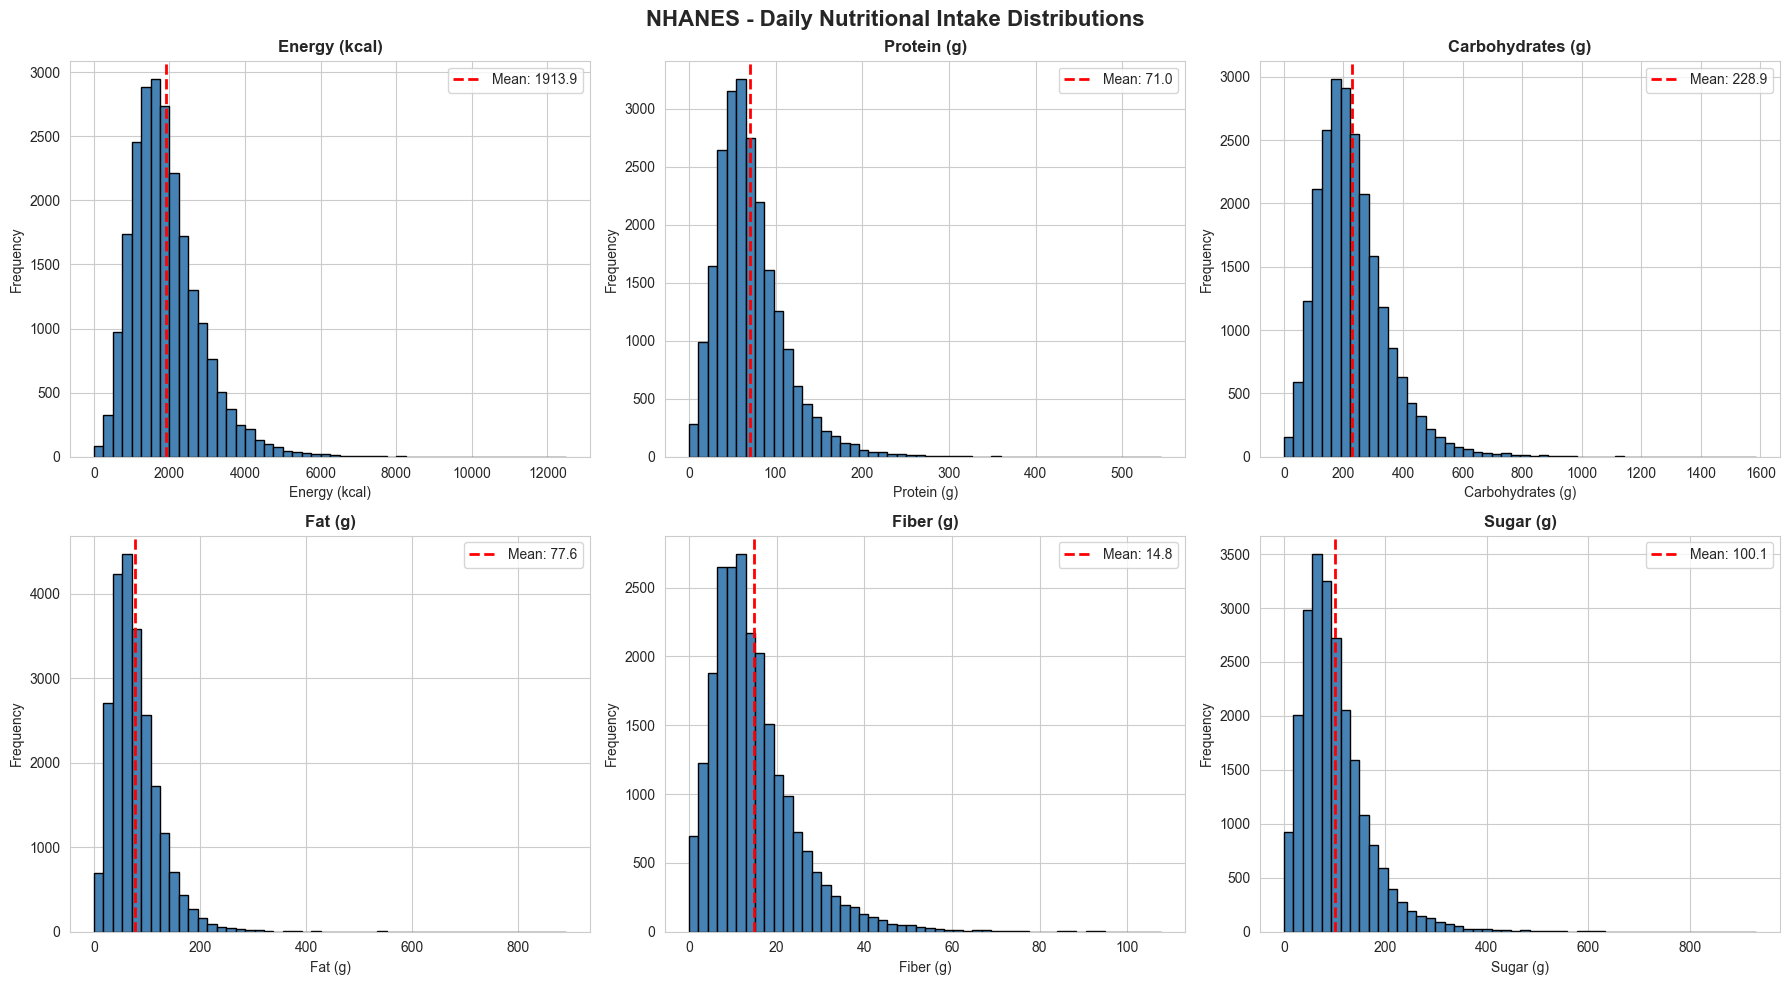

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('NHANES - Daily Nutritional Intake Distributions', fontsize=16, fontweight='bold')

nutrients = [
    ('energy_kcal', 'Energy (kcal)'),
    ('protein_g', 'Protein (g)'),
    ('carbs_g', 'Carbohydrates (g)'),
    ('fat_g', 'Fat (g)'),
    ('fiber_g', 'Fiber (g)'),
    ('sugar_g', 'Sugar (g)')
]

for idx, (col, title) in enumerate(nutrients):
    ax = axes[idx // 3, idx % 3]
    if col in df_nhanes.columns:
        df_nhanes[col].hist(bins=50, ax=ax, color='steelblue', edgecolor='black')
        ax.set_title(title, fontweight='bold')
        ax.set_xlabel(title)
        ax.set_ylabel('Frequency')
        
        mean_val = df_nhanes[col].mean()
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
        ax.legend()

plt.tight_layout()
plt.show()

### 7.2 NHANES - Demographics Analysis

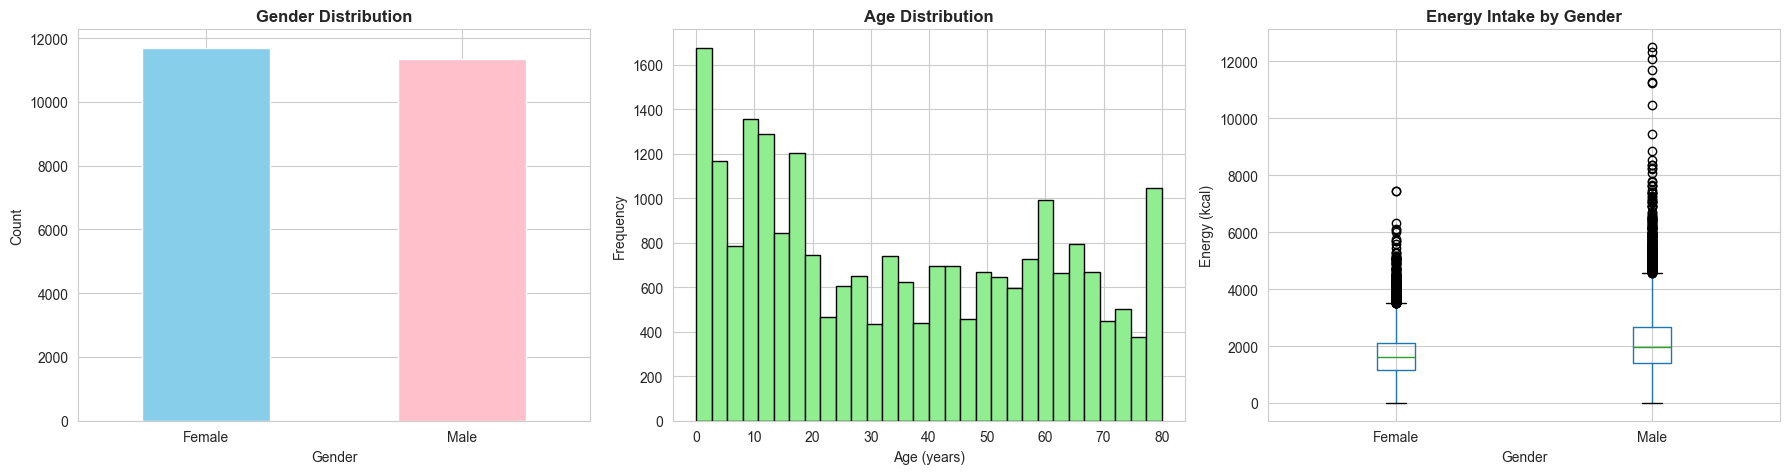

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('NHANES - Demographic Distributions', fontsize=16, fontweight='bold')

# Gender distribution
gender_map = {1: 'Male', 2: 'Female'}
df_nhanes['gender_label'] = df_nhanes['gender'].map(gender_map)
df_nhanes['gender_label'].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'pink'])
axes[0].set_title('Gender Distribution', fontweight='bold')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Age distribution
df_nhanes['age'].hist(bins=30, ax=axes[1], color='lightgreen', edgecolor='black')
axes[1].set_title('Age Distribution', fontweight='bold')
axes[1].set_xlabel('Age (years)')
axes[1].set_ylabel('Frequency')

# Energy intake by gender
df_nhanes.boxplot(column='energy_kcal', by='gender_label', ax=axes[2])
axes[2].set_title('Energy Intake by Gender', fontweight='bold')
axes[2].set_xlabel('Gender')
axes[2].set_ylabel('Energy (kcal)')
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

In [ ]:
def extract_nutrition_from_recipes(df):
    """
    Extract nutritional values from recipe nutrients column.
    """
    nutrition_data = []
    
    for idx, row in df.iterrows():
        try:
            nutrients = ast.literal_eval(row['nutrients']) if pd.notna(row['nutrients']) else {}
            
            # Extract calories
            calories_str = nutrients.get('calories', '0 kcal')
            calories = float(calories_str.split()[0]) if calories_str else 0
            
            # Extract protein
            protein_str = nutrients.get('proteinContent', '0 g')
            protein = float(protein_str.split()[0]) if protein_str else 0
            
            # Extract carbs
            carbs_str = nutrients.get('carbohydrateContent', '0 g')
            carbs = float(carbs_str.split()[0]) if carbs_str else 0
            
            # Extract fat
            fat_str = nutrients.get('fatContent', '0 g')
            fat = float(fat_str.split()[0]) if fat_str else 0
            
            nutrition_data.append({
                'recipe_id': idx,
                'calories': calories,
                'protein': protein,
                'carbs': carbs,
                'fat': fat
            })
        except:
            continue
    
    return pd.DataFrame(nutrition_data)

df_recipe_nutrition = extract_nutrition_from_recipes(df_recipes)
df_recipe_nutrition = df_recipe_nutrition[df_recipe_nutrition['calories'] > 0]

print(f"Extracted nutrition for {len(df_recipe_nutrition):,} recipes")
print("\nRecipe Nutritional Statistics:")
print(df_recipe_nutrition.describe())

Extracted nutrition for 37,674 recipes

Recipe Nutritional Statistics:
          recipe_id      calories       protein         carbs           fat
count  37674.000000  37674.000000  37674.000000  37674.000000  37674.000000
mean   19110.937012    323.642592     13.398498     31.327972     16.426103
std    11036.927834    216.496895     14.585783     24.714700     15.081851
min        0.000000      1.000000      0.000000      0.000000      0.000000
25%     9546.250000    172.000000      3.000000     13.000000      6.000000
50%    19116.500000    288.000000      8.000000     27.000000     13.000000
75%    28665.750000    429.000000     21.000000     44.000000     23.000000
max    38236.000000   5701.000000    519.000000    622.000000    433.000000


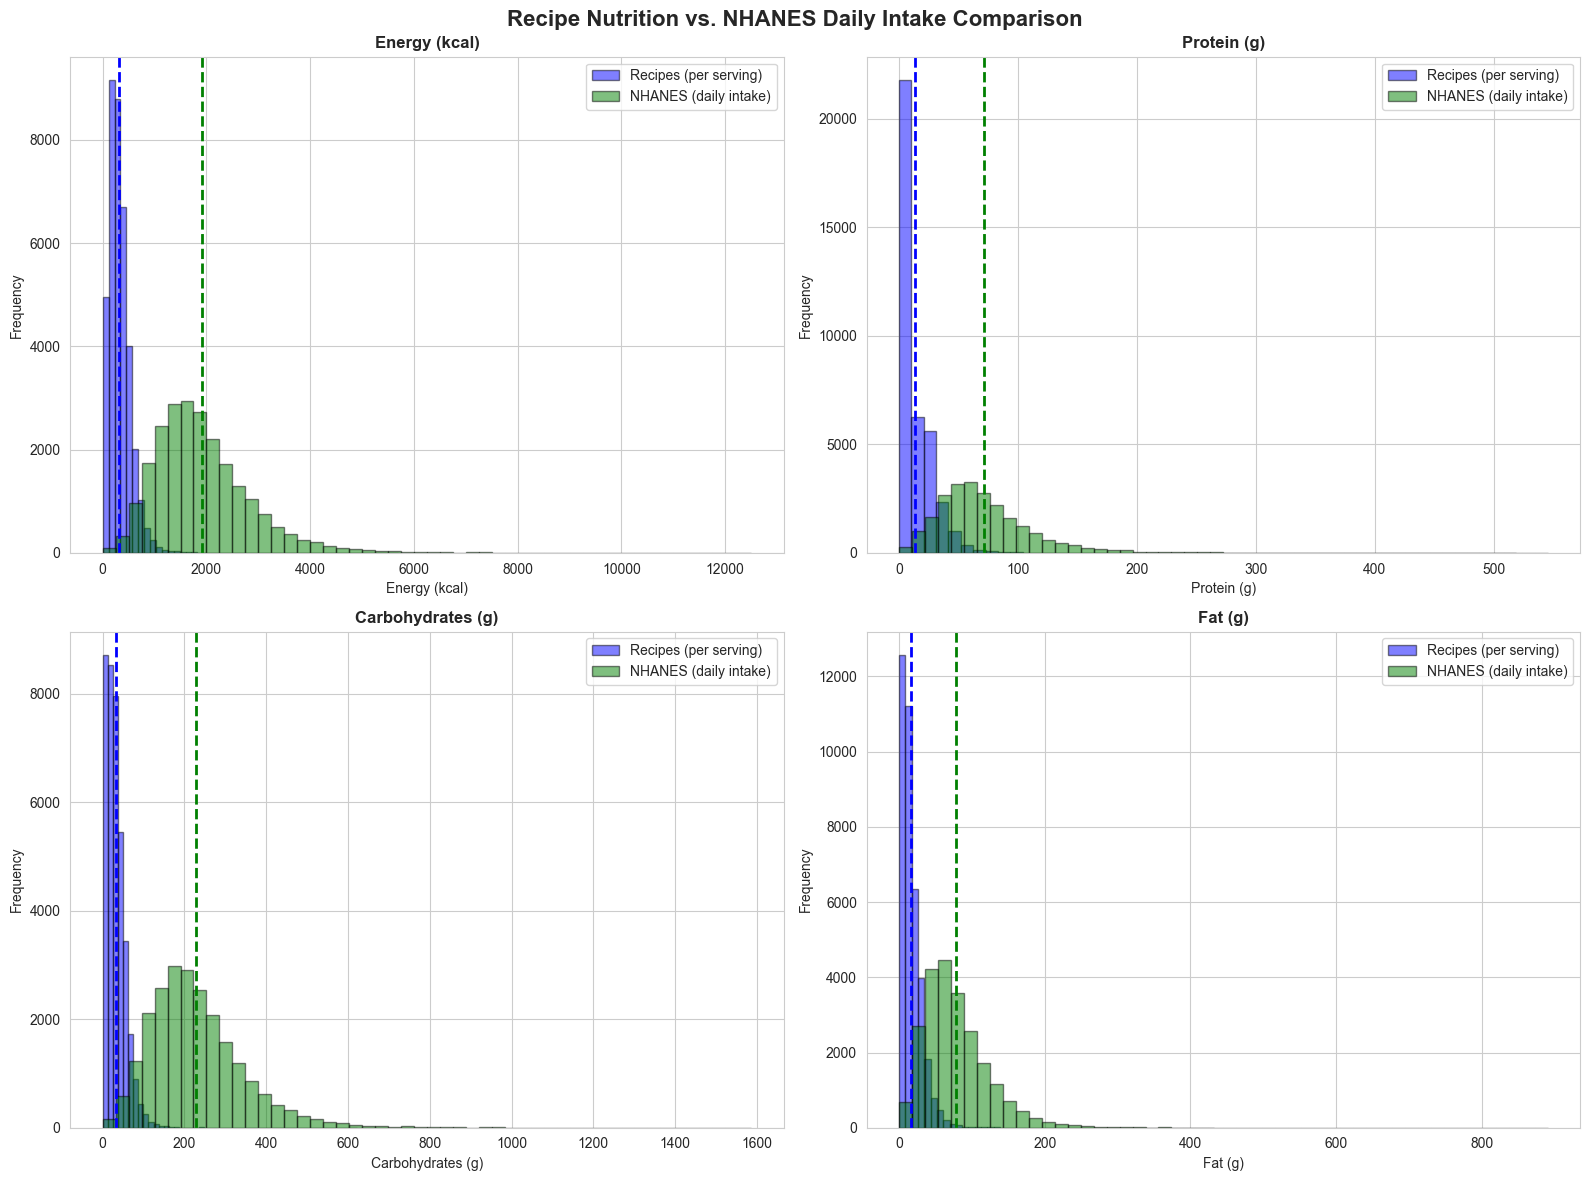

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Recipe Nutrition vs. NHANES Daily Intake Comparison', fontsize=16, fontweight='bold')

comparisons = [
    ('calories', 'energy_kcal', 'Energy (kcal)'),
    ('protein', 'protein_g', 'Protein (g)'),
    ('carbs', 'carbs_g', 'Carbohydrates (g)'),
    ('fat', 'fat_g', 'Fat (g)')
]

for idx, (recipe_col, nhanes_col, title) in enumerate(comparisons):
    ax = axes[idx // 2, idx % 2]
    
    ax.hist(df_recipe_nutrition[recipe_col], bins=50, alpha=0.5, label='Recipes (per serving)', 
            color='blue', edgecolor='black')
    ax.hist(df_nhanes[nhanes_col], bins=50, alpha=0.5, label='NHANES (daily intake)', 
            color='green', edgecolor='black')
    
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel(title)
    ax.set_ylabel('Frequency')
    ax.legend()
    
    recipe_mean = df_recipe_nutrition[recipe_col].mean()
    nhanes_mean = df_nhanes[nhanes_col].mean()
    ax.axvline(recipe_mean, color='blue', linestyle='--', linewidth=2)
    ax.axvline(nhanes_mean, color='green', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()